In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import tqdm 
import RNN_Task as task # This is the task module

In [24]:
T_stim = 24 # length of stimulus display period
T_delay = 16 # length of delay period
T_resp = 24 # length of response period
stim_dim = 36 # dimensionality of the stimulus (degrees around the circle)

# 37 inputs to the network: 36 for the stimulus, 1 for the "go" cue

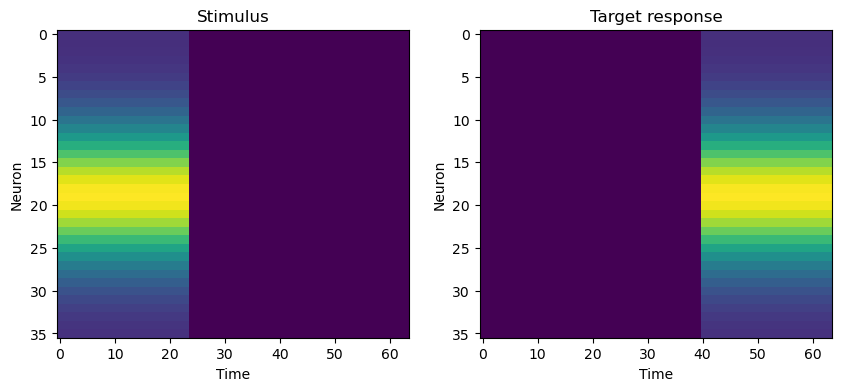

In [25]:
# Plot a trial of the task 
task.plot_trial(T_stim=T_stim, T_delay=T_delay, T_resp=T_resp, stim_dim=stim_dim)

In [42]:
# Activation function, F
# Current hidden state, h_t
# Current input, x_t
# Recurrent weights, M
# Feedforward weights, W
# Readout weights, R
# Biases b
# Memory constant, alpha (representing strength of update over time)
    # alpha = 1: no memory
    # alpha = 0: infinite memory (no update)
# Update equation (discretised): h_t+1 = (1 - alpha) * h_t + alpha * F(M * h_t + W * x_t + b)

class rnn(nn.Module): # simple RNN with one recurrent layer
    def __init__(self, stim_dim, recurrent_units,alpha):
        super().__init__()
        self.recurrent_units = recurrent_units
        self.stim_dim = stim_dim
        self.alpha = alpha

        # Building the layers using a dictionary
        self.Layer = nn.ModuleDict({
            'Input' : nn.Linear(stim_dim+1, recurrent_units),
            'Recurrent' : nn.Linear(recurrent_units, recurrent_units),
            'Output' : nn.Linear(recurrent_units, stim_dim),
        })
    
    def forward(self, X): # Forward method with input data X (takes in an entire time series of inputs)
        # X is a tensor of shape (batch_size, total_timecourse, stim_dim+1)
        batch_size = X.shape[0]
        total_timecourse = X.shape[1]
        h = torch.zeros(batch_size, self.recurrent_units) # initialise hidden activities at 0 (network begins every episode at h=0)
        Y = torch.zeros(batch_size, total_timecourse, self.stim_dim) # initial output (initialised at 0)
        for t in range(total_timecourse):
            Y[:,t,:], h = self.forward_one_step(X[:,t,:], h) # looping through timesteps, updating Y to be the output of the network, and h to be the hidden activity at the current timestep
        return Y

    def forward_one_step(self, x, h): # Takes the input and the hidden activity at the current timestep, and generates next output
        # x is a tensor of shape (bath_size, stim_dim+1)
        # h is a tensor of shape (batch_size, recurrent_units)
        h_new = (1 - self.alpha) * h + self.alpha * F.relu(self.Layer['Input'](x) + self.Layer['Recurrent'](h)) # input layer applied to x and recurrent layer applied to h, with a softplus activation function
        y = self.Layer['Output'](h_new) # output layer applied to h_new
        return y, h_new


# Make a network
model = rnn(stim_dim=stim_dim, recurrent_units = 120, alpha = 0.3)

In [43]:
# Loss function (MSE)
loss_function = nn.MSELoss()

In [44]:
# Optimiser
optimiser = optim.Adam(model.parameters(), lr = 0.005)

In [45]:
# Train the model
losses = []
for episode in tqdm.tqdm(range(2200)):
    X, Y = task.task(T_stim=T_stim, T_delay=T_delay, T_resp=T_resp, stim_dim=stim_dim, batch_size=32) # generate a batch of trials
    # forward pass
    Y_pred = model(X) # make predictions
    # compute loss
    loss = loss_function(Y_pred, Y) # compute loss
    # backward pass
    optimiser.zero_grad() # zero gradients to prevent accumulation
    loss.backward() # compute gradients using backprop
    optimiser.step() # update parameters
    # store loss
    losses.append(loss.detach().numpy()) # converts into a number


100%|██████████| 2200/2200 [06:01<00:00,  6.08it/s]


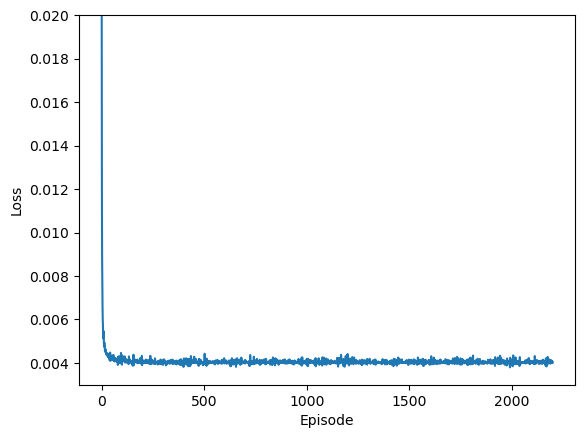

In [52]:
# Visualise loss curve
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
# make y axis start at 0.003
axes = plt.gca()
axes.set_ylim([0.003,0.02])
plt.show()